Chapter 1 - part 4
======
***


## Example: Inferring behaviour from text-message data

Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages:

>  You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this? (This is in fact my own text-message data. Judge my popularity as you wish.)


In [14]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

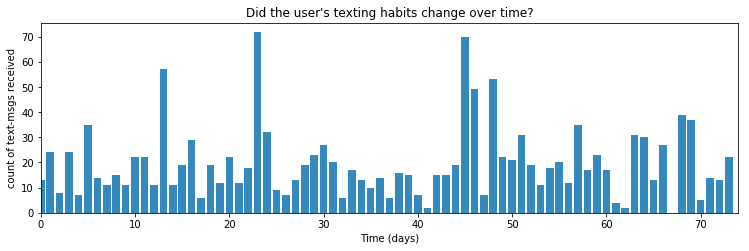

In [15]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

Before we start modeling, see what you can figure out just by looking at the chart above. Would you say there was a change in behaviour during this time period? 

How can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of *count* data. Denoting day $i$'s text-message count by $C_i$, 

$$ C_i \sim \text{Poisson}(\lambda)  $$

We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations. (Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)

How can we represent this observation mathematically? Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *switchpoint*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice.  A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 

An alternative, and something I encourage the reader to try, would be to have two priors: one for each $\lambda_i$. Creating two exponential distributions with different $\alpha$ values reflects our prior belief that the rate changed at some point during the observations.

What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

So after all this, what does our overall prior distribution for the unknown variables look like? Frankly, *it doesn't matter*. What we should understand is that it's an ugly, complicated mess involving symbols only a mathematician could love. And things will only get uglier the more complicated our models become. Regardless, all we really care about is the posterior distribution.

We next turn to PyMC3, a Python library for performing Bayesian analysis that is undaunted by the mathematical monster we have created. 


Introducing our first hammer: PyMC3
-----

PyMC3 is a Python library for programming Bayesian analysis [3]. It is a fast, well-maintained library. The only unfortunate part is that its documentation is lacking in certain areas, especially those that bridge the gap between beginner and hacker. One of this book's main goals is to solve that problem, and also to demonstrate why PyMC3 is so cool.

We will model the problem above using PyMC3. This type of programming is called *probabilistic programming*, an unfortunate misnomer that invokes ideas of randomly-generated code and has likely confused and frightened users away from this field. The code is not random; it is probabilistic in the sense that we create probability models using programming variables as the model's components. Model components are first-class primitives within the PyMC3 framework. 

B. Cronin [5] has a very motivating description of probabilistic programming:

>   Another way of thinking about this: unlike a traditional program, which only runs in the forward directions, a probabilistic program is run in both the forward and backward direction. It runs forward to compute the consequences of the assumptions it contains about the world (i.e., the model space it represents), but it also runs backward from the data to constrain the possible explanations. In practice, many probabilistic programming systems will cleverly interleave these forward and backward operations to efficiently home in on the best explanations.

Because of the confusion engendered by the term *probabilistic programming*, I'll refrain from using it. Instead, I'll simply say *programming*, since that's what it really is. 

PyMC3 code is easy to read. The only novel thing should be the syntax. Simply remember that we are representing the model's components ($\tau, \lambda_1, \lambda_2$ ) as variables.

In [3]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

/Users/edoardo/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.05065023956194388


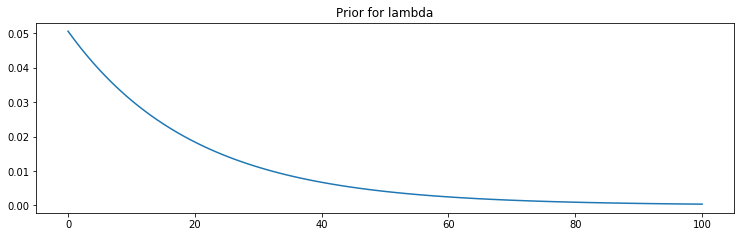

In [5]:
# MY ADDITION

from scipy.stats import expon

lambda_ =  1.0/count_data.mean()
print(lambda_)

x = np.linspace(0,100,100)
y = [expon.pdf(xi, scale=1/lambda_) for xi in x]

plt.plot(x,y)
plt.title('Prior for lambda')
plt.show()

In the code above, we create the PyMC3 variables corresponding to $\lambda_1$ and $\lambda_2$. We assign them to PyMC3's *stochastic variables*, so-called because they are treated by the back end as random number generators.

In [6]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. The `switch()` function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. The values of `lambda_` up until `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note that because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are **not** fixing any variables yet.

In [7]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

The variable `observation` combines our data, `count_data`, with our proposed data-generation scheme, given by the variable `lambda_`, through the `observed` keyword. 

The code below will be explained in Chapter 3, but I show it here so you can see where our results come from. One can think of it as a *learning* step. The machinery being employed is called *Markov Chain Monte Carlo* (MCMC), which I also delay explaining until Chapter 3. This technique returns thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$. We can plot a histogram of the random variables to see what the posterior distributions look like. Below, we collect the samples (called *traces* in the MCMC literature) into histograms.

In [8]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
The number of effective samples is smaller than 25% for some parameters.


In [9]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

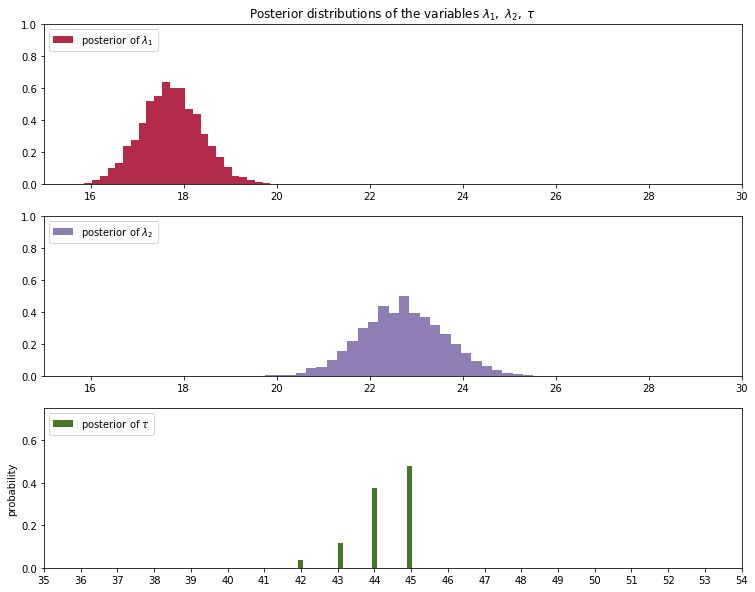

In [13]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
#plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
#plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
#plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

### Interpretation

Recall that Bayesian methodology returns a *distribution*. Hence we now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

What other observations can you make? If you look at the original data again, do these results seem reasonable? 

Notice also that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. But that's OK! This is one of the benefits of taking a computational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable (and messy) distribution. Our use of a computational approach makes us indifferent to mathematical tractability.

Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points. 

### Why would I want samples from the posterior, anyways?


We will deal with this question for the remainder of the book, and it is an understatement to say that it will lead us to some amazing results. For now, let's end this chapter with one more example.

We'll use the posterior samples to answer the following question: what is the expected number of texts at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to *what is the expected value of $\lambda$ at time $t$*?

In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$. 

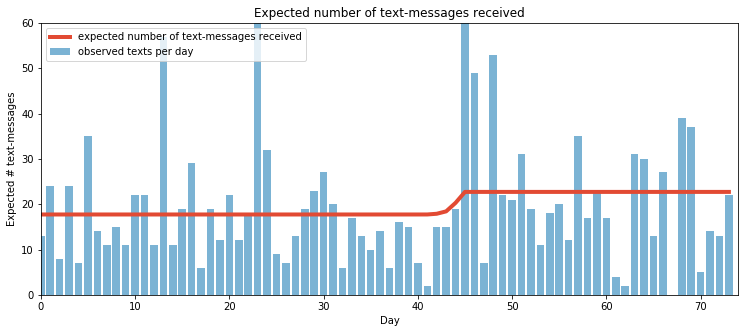

In [11]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

Our analysis shows strong support for believing the user's behavior did change ($\lambda_1$ would have been close in value to $\lambda_2$ had this not been true), and that the change was sudden rather than gradual (as demonstrated by $\tau$'s strongly peaked posterior distribution). We can speculate what might have caused this: a cheaper text-message rate, a recent weather-to-text subscription, or perhaps a new relationship. (In fact, the 45th day corresponds to Christmas, and I moved away to Toronto the next month, leaving a girlfriend behind.)


### References


-  [1] Gelman, Andrew. N.p.. Web. 22 Jan 2013. [N is never large enough](http://andrewgelman.com/2005/07/31/n_is_never_larg).
-  [2] Norvig, Peter. 2009. [The Unreasonable Effectiveness of Data](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf).
- [3] Salvatier, J, Wiecki TV, and Fonnesbeck C. (2016) Probabilistic programming in Python using PyMC3. *PeerJ Computer Science* 2:e55 <https://doi.org/10.7717/peerj-cs.55>
- [4] Jimmy Lin and Alek Kolcz. Large-Scale Machine Learning at Twitter. Proceedings of the 2012 ACM SIGMOD International Conference on Management of Data (SIGMOD 2012), pages 793-804, May 2012, Scottsdale, Arizona.
- [5] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.